# Final Year Major Project

**Project Title:** Intelligent Laptop Recommendation System  
**Student Name:** Bishwadeep Rajbongshi  
**Enrollment Number:** A9922522002621(el)  
**Specialization:** Data Analystics  
**Submission Date:** [Date]  

---

## Executive Summary

This project presents an interactive, data-driven system to recommend laptops based on user preferences. Leveraging Python, pandas, and ipywidgets, the tool allows users to filter devices by brand, category, operating system, RAM, storage, weight, screen size, and budget (with currency conversion). The system also scores devices for gaming, editing, and art use-cases, providing both tabular and visual recommendations. This notebook demonstrates the complete workflow from data cleaning to user interaction and visualization.

## Table of Contents

1. [Introduction](#introduction)
2. [Data Loading and Cleaning](#data-loading-and-cleaning)
3. [Widget Setup](#widget-setup)
4. [Currency Handling](#currency-handling)
5. [Use-case Scoring](#use-case-scoring)
6. [Recommendation Logic](#recommendation-logic)
7. [Conclusion & Future Work](#conclusion--future-work)

## 1. Introduction

Choosing the right laptop can be challenging due to the variety of options and specifications. This project aims to simplify the process by providing an intelligent recommendation system that adapts to user needs and budgets.

## 2. Data Loading and Cleaning

The following section loads the laptop dataset, cleans and standardizes the data, and prepares it for analysis and filtering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

In [2]:
# --- 1. Load and clean data ---
df = pd.read_csv('laptops.csv', encoding='latin1')
df.columns = [c.strip().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

df = df.rename(columns={
    'Model_Na': 'Model_Name',
    'Screen_Siz': 'Screen_Size',
    'Operating': 'Operating_System',
    'Operating_Weight': 'Weight',
    'Price_Euros': 'Price_Euros'
})

df['RAM'] = df['RAM'].astype(str).str.replace('GB', '', regex=False).str.extract('(\d+)').astype(float)
df['Weight'] = df['Weight'].astype(str).str.replace('kg', '', regex=False).str.extract('(\d+\.?\d*)').astype(float)
df['Price_Euros'] = df['Price_Euros'].astype(str).str.replace(',', '.', regex=False).str.extract('(\d+\.?\d*)').astype(float)

def storage_to_gb(val):
    if pd.isnull(val):
        return np.nan
    val = str(val).upper()
    total = 0
    for part in val.split('+'):
        part = part.strip()
        try:
            if 'TB' in part:
                num = ''.join([c for c in part if c.isdigit() or c == '.'])
                total += float(num) * 1024
            elif 'GB' in part:
                num = ''.join([c for c in part if c.isdigit() or c == '.'])
                total += float(num)
        except:
            continue  # skip parts like 'SSD' or malformed chunks
    return total if total > 0 else np.nan

df['Storage_GB'] = df['Storage'].apply(storage_to_gb)
df['Operating_System'] = df['Operating_System'].astype(str).str.strip()
df['Manufacturer'] = df['Manufacturer'].astype(str).str.strip()
df['Category'] = df['Category'].astype(str).str.strip()


### Data Overview Visualizations

Let's explore the dataset visually to understand the distribution of brands and prices.

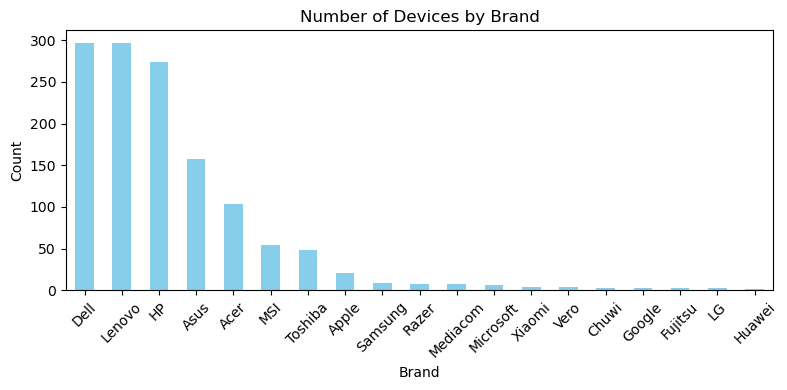

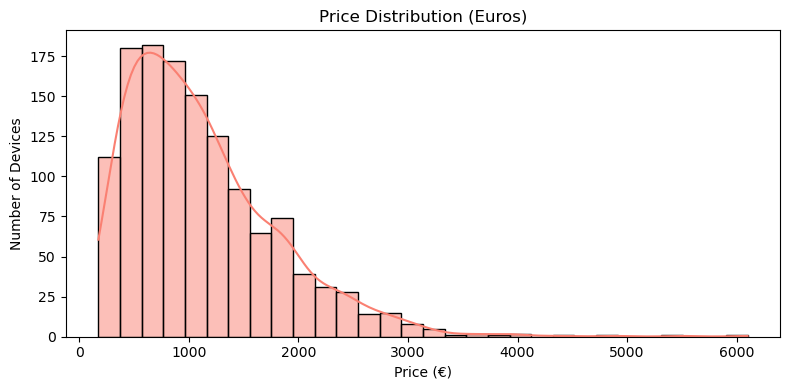

In [3]:
# Brand distribution
plt.figure(figsize=(8,4))
df['Manufacturer'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Devices by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df['Price_Euros'], bins=30, kde=True, color='salmon')
plt.title('Price Distribution (Euros)')
plt.xlabel('Price (€)')
plt.ylabel('Number of Devices')
plt.tight_layout()
plt.show()

### Correlation Heatmap

Visualizing correlations between numeric features (RAM, Storage, Weight, Price).

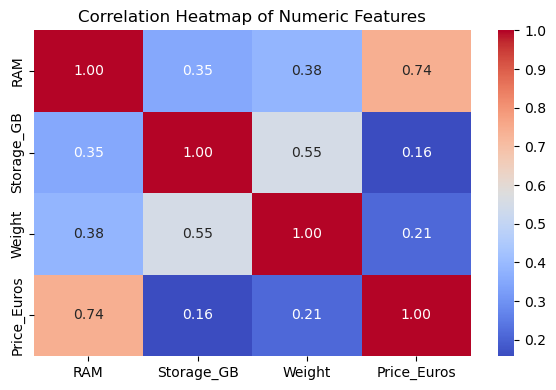

In [4]:
numeric_cols = ['RAM', 'Storage_GB', 'Weight', 'Price_Euros']
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

## 3. Widget Setup

This section creates interactive widgets for users to specify their laptop preferences, such as brand, category, OS, RAM, storage, weight, price, and screen size.

In [5]:
#Widget Setup

# Brand (with ALL)
brands = list(sorted(df['Manufacturer'].dropna().unique()))
brands.insert(0, "ALL")
manufacturer_widget = widgets.SelectMultiple(
    options=brands,
    value=("ALL",),
    description='Brand:',
    style={'description_width': 'initial'}
)

# Category (with ALL)
categories = list(sorted(df['Category'].dropna().unique()))
categories.insert(0, "ALL")
category_widget = widgets.Dropdown(
    options=categories,
    value="ALL",
    description='Category:',
    style={'description_width': 'initial'}
)

# OS (with ALL)
oses = list(sorted(df['Operating_System'].dropna().unique()))
oses.insert(0, "ALL")
os_widget = widgets.SelectMultiple(
    options=oses,
    value=("ALL",),
    description='OS:',
    style={'description_width': 'initial'}
)

# RAM
ram_widget = widgets.IntSlider(
    value=8, min=int(df['RAM'].min()), max=int(df['RAM'].max()), step=4,
    description='Min RAM (GB):',
    style={'description_width': 'initial'}
)

# Storage: More standard sizes including 64GB and 256GB
standard_storage = [64, 128, 256, 512, 1024, 2048]
storage_widget = widgets.SelectionSlider(
    options=standard_storage,
    value=256,
    description='Min Storage (GB):',
    style={'description_width': 'initial'}
)

# Weight
weight_widget = widgets.FloatSlider(
    value=2.0, min=float(df['Weight'].min()), max=float(df['Weight'].max()), step=0.1,
    description='Max Weight (kg):',
    style={'description_width': 'initial'}
)

# Price
price_widget = widgets.IntSlider(
    value=1000, min=int(df['Price_Euros'].min()), max=int(df['Price_Euros'].max()), step=50,
    description='Budget (€):',
    style={'description_width': 'initial'}
)

# Screen Size
screen_widget = widgets.FloatSlider(
    value=13.0, 
    min=float(df['Screen_Size'].str.replace('"','').astype(float).min()), 
    max=float(df['Screen_Size'].str.replace('"','').astype(float).max()), 
    step=0.1,
    description='Min Screen (in):',
    style={'description_width': 'initial'}
)

button = widgets.Button(description='Recommend Devices', button_style='success')
output = widgets.Output()


## 4. Currency Handling

Here, we set up currency conversion to allow users to view prices in either Euros or US Dollars.

In [6]:
# --- 2. Currency setup ---
EXCHANGE_RATES = {'€': 1, '$': 1.08}
CURRENCY_LABELS = {'€': 'Euro (€)', '$': 'Dollar ($)'}

df['Price_Dollars'] = df['Price_Euros'] * EXCHANGE_RATES['$']

## 5. Widget Setup (with Currency)

This section extends the widget setup to include currency selection and dynamic budget adjustment.

In [7]:
# --- 3. Widget Setup ---
brands = list(sorted(df['Manufacturer'].dropna().unique()))
brands.insert(0, "ALL")
manufacturer_widget = widgets.SelectMultiple(
    options=brands, value=("ALL",), description='Brand:', style={'description_width': 'initial'}
)

categories = list(sorted(df['Category'].dropna().unique()))
categories.insert(0, "ALL")
category_widget = widgets.Dropdown(
    options=categories, value="ALL", description='Category:', style={'description_width': 'initial'}
)

oses = list(sorted(df['Operating_System'].dropna().unique()))
oses.insert(0, "ALL")
os_widget = widgets.SelectMultiple(
    options=oses, value=("ALL",), description='OS:', style={'description_width': 'initial'}
)

ram_widget = widgets.IntSlider(
    value=8, min=int(df['RAM'].min()), max=int(df['RAM'].max()), step=2,
    description='Min RAM (GB):', style={'description_width': 'initial'}
)
# More storage options including 64GB and 256GB
standard_storage = [64, 128, 256, 512, 1024, 2048]
storage_widget = widgets.SelectionSlider(
    options=standard_storage, value=256, description='Min Storage (GB):',
    style={'description_width': 'initial'}
)
weight_widget = widgets.FloatSlider(
    value=2.0, min=float(df['Weight'].min()), max=float(df['Weight'].max()), step=0.1,
    description='Max Weight (kg):', style={'description_width': 'initial'}
)
screen_widget = widgets.FloatSlider(
    value=13.0,
    min=float(df['Screen_Size'].str.replace('"','').astype(float).min()),
    max=float(df['Screen_Size'].str.replace('"','').astype(float).max()),
    step=0.1,
    description='Min Screen (in):', style={'description_width': 'initial'}
)

# Currency dropdown
currency_widget = widgets.Dropdown(
    options=[('Euro (€)', '€'), ('Dollar ($)', '$')],
    value='€',
    description='Currency:', style={'description_width': 'initial'}
)

# Budget slider (created dynamically)
def get_budget_slider(selected_currency, df):
    rate = EXCHANGE_RATES[selected_currency]
    min_value = int(df['Price_Euros'].min() * rate)
    max_value = int(df['Price_Euros'].max() * rate)
    return widgets.IntSlider(
        value=min_value,
        min=min_value,
        max=max_value,
        step=50,
        description=f"Budget ({selected_currency}):",
        style={'description_width': 'initial'}
    )

price_widget = get_budget_slider(currency_widget.value, df)

def on_currency_change(change):
    with output:
        global price_widget
        rate = EXCHANGE_RATES[change['new']]
        # Save current value in euros before switching
        current_value_euro = price_widget.value / EXCHANGE_RATES[currency_widget.value]
        new_slider = get_budget_slider(change['new'], df)
        # Try to keep previous value if in range
        new_val = int(current_value_euro * rate)
        if new_slider.min <= new_val <= new_slider.max:
            new_slider.value = new_val
        price_widget.value = new_slider.value
        price_widget.min = new_slider.min
        price_widget.max = new_slider.max
        price_widget.description = new_slider.description

currency_widget.observe(on_currency_change, names='value')

button = widgets.Button(description='Recommend Devices', button_style='success')
output = widgets.Output()

## 6. Use-case Scoring

Each device is scored for suitability in gaming, editing, and art/design based on its specifications.

In [8]:
# --- 4. Use-case Scoring ---
def compute_usecase_scores(row):
    gaming = (row['RAM'] >= 16) and (('Nvidia' in str(row['GPU'])) or ('AMD' in str(row['GPU'])))
    editing = (row['RAM'] >= 16) and any(x in str(row['CPU']) for x in ['i7', 'Ryzen 7', 'i9'])
    art = 'IPS' in str(row['Screen']) or 'OLED' in str(row['Screen'])
    return pd.Series({
        'Gaming_Score': int(gaming),
        'Editing_Score': int(editing),
        'Art_Score': int(art)
    })

scores = df.apply(compute_usecase_scores, axis=1)
df = pd.concat([df, scores], axis=1)

### Use-case Score Distribution

Visualizing how many devices are suitable for Gaming, Editing, and Art/Design.

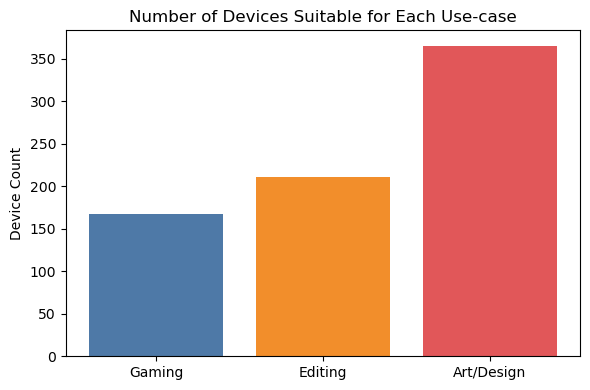

In [9]:
usecase_counts = {
    'Gaming': df['Gaming_Score'].sum(),
    'Editing': df['Editing_Score'].sum(),
    'Art/Design': df['Art_Score'].sum()
}
plt.figure(figsize=(6,4))
plt.bar(usecase_counts.keys(), usecase_counts.values(), color=['#4e79a7','#f28e2b','#e15759'])
plt.title('Number of Devices Suitable for Each Use-case')
plt.ylabel('Device Count')
plt.tight_layout()
plt.show()

## 7. Recommendation Logic

The following code filters devices based on user input, displays the top recommendations, and visualizes them.

In [10]:
# --- 5. Recommendation Logic with currency-aware filtering/output ---
def recommend_devices(b):
    with output:
        clear_output()
        selected_currency = currency_widget.value
        rate = EXCHANGE_RATES[selected_currency]
        filtered = df.copy()
        if "ALL" not in manufacturer_widget.value:
            filtered = filtered[filtered['Manufacturer'].isin(manufacturer_widget.value)]
        if "ALL" not in os_widget.value:
            filtered = filtered[filtered['Operating_System'].isin(os_widget.value)]
        if category_widget.value != "ALL":
            filtered = filtered[filtered['Category'] == category_widget.value]
        filtered = filtered[
            (filtered['RAM'] >= ram_widget.value) &
            (filtered['Storage_GB'] >= storage_widget.value) &
            (filtered['Weight'] <= weight_widget.value) &
            ((filtered['Price_Euros'] * rate) <= price_widget.value) &
            (filtered['Screen_Size'].str.replace('"','').astype(float) >= screen_widget.value)
        ]
        if filtered.empty:
            print('No devices match your criteria.')
            return
        recs = filtered.sort_values(by='Price_Euros').head(10)
        recs = recs.copy()
        recs['Display_Price'] = (recs['Price_Euros'] * rate).round(2)
        display_cols = [
            'Manufacturer', 'Model_Name', 'CPU', 'GPU', 'RAM', 'Storage', 'Screen', 'Operating_System',
            'Weight', 'Display_Price', 'Gaming_Score', 'Editing_Score', 'Art_Score'
        ]
        display(recs[display_cols].rename(columns={'Display_Price': f'Price ({selected_currency})'}))
        plt.figure(figsize=(10,5))
        sns.barplot(x='Model_Name', y='Display_Price', hue='Manufacturer', data=recs, dodge=False)
        plt.title(f'Top Device Recommendations (by Price in {selected_currency})')
        plt.xticks(rotation=25)
        plt.ylabel(f'Price ({selected_currency})')
        plt.tight_layout()
        plt.show()

button.on_click(recommend_devices)

display(
    manufacturer_widget, category_widget, os_widget, ram_widget, storage_widget,
    weight_widget, currency_widget, price_widget, screen_widget, button, output
)

SelectMultiple(description='Brand:', index=(0,), options=('ALL', 'Acer', 'Apple', 'Asus', 'Chuwi', 'Dell', 'Fu…

Dropdown(description='Category:', options=('ALL', '2 in 1 Convertible', 'Gaming', 'Netbook', 'Notebook', 'Ultr…

SelectMultiple(description='OS:', index=(0,), options=('ALL', 'Android', 'Chrome OS', 'Linux', 'Mac OS', 'No O…

IntSlider(value=8, description='Min RAM (GB):', max=64, min=2, step=2, style=SliderStyle(description_width='in…

SelectionSlider(description='Min Storage (GB):', index=2, options=(64, 128, 256, 512, 1024, 2048), style=Descr…

FloatSlider(value=2.0, description='Max Weight (kg):', max=4.7, min=0.69, style=SliderStyle(description_width=…

Dropdown(description='Currency:', options=(('Euro (€)', '€'), ('Dollar ($)', '$')), style=DescriptionStyle(des…

IntSlider(value=174, description='Budget (€):', max=6099, min=174, step=50, style=SliderStyle(description_widt…

FloatSlider(value=13.0, description='Min Screen (in):', max=18.4, min=10.1, style=SliderStyle(description_widt…

Button(button_style='success', description='Recommend Devices', style=ButtonStyle())

Output()

### Recommendation Summary Visualization

After generating recommendations, visualize the distribution of recommended devices by category.

In [11]:
# This cell should be run after recommendations are generated (after running the recommend_devices function)
if 'recs' in locals() and not recs.empty:
    plt.figure(figsize=(6,6))
    recs['Category'].value_counts().plot.pie(autopct='%1.0f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Recommended Devices by Category')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
else:
    print("Run the recommendation first to see the summary visualization.")

Run the recommendation first to see the summary visualization.


## Conclusion & Future Work

This project demonstrates a robust, extensible system for laptop recommendations. Future enhancements could include:
- Integration with live pricing APIs for real-time data.
- More granular use-case scoring.
- Deployment as a web application.
- User feedback loop for improved recommendations.

---
**Thank you for reviewing this project!**